In [41]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

sys.path.insert(1, '../')

from rule_extraction import *

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
dataPairs = []

directories = []
for root, dirs, files in os.walk("../../data/data-cluster-examples-pause"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    print(f"Processing {directory}")

    # if "fallingDrop" not in directory:
    #     print(f"Skipping {directory}")
    #     continue

    files = os.listdir(directory)

    # group files by time AutoPas_liveInfoLogger_Rank0_$2024-05-21_14-24-17$
    data_pairs = {}
    for file in files:
        if "tuningData" in file or "liveInfo" in file:
            time = file.split("_")[-1]

            if not time in data_pairs:
                data_pairs[time] = [None, None]

            if "tuningData" in file:
                data_pairs[time][1] = pd.read_csv(
                    os.path.join(directory, file))
            elif "liveInfo" in file:
                data_pairs[time][0] = pd.read_csv(
                    os.path.join(directory, file))

    # check if tuning and liveInfo files are present
    for time, pair in data_pairs.items():
        if pair[0] is None or pair[1] is None:
            print(f"Missing file for {directory} at time {time}")
            continue

    # filter rows where NaN is present

    for time, (liveInfo, tuningData) in data_pairs.items():
        tuning_iterations = tuningData["Iteration"]

        corresponding_liveInfo = liveInfo.loc[liveInfo["Iteration"].isin(
            tuning_iterations)]

        # assert len(corresponding_liveInfo) == len(
        #     tuningData), "Length of liveInfo and tuningData does not match"

        # strip columns
        corresponding_liveInfo.columns = corresponding_liveInfo.columns.str.strip()
        tuningData.columns = tuningData.columns.str.strip()

        # merge container and Data Layout
        tuningData["Container_DataLayout"] = tuningData["Container"] + \
            "_" + tuningData["Data Layout"]

        # tuningData.drop(columns=["Container", "Data Layout"], inplace=True)

        dataPairs.append((corresponding_liveInfo, tuningData))

        # describe data
        # print(f"Time: {time}")
        # print(corresponding_liveInfo["avgParticlesPerCell"].describe())
        # print("")

Processing ../../data/data-cluster-examples-pause/uniformCube_b_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_2
Processing ../../data/data-cluster-examples-pause/uniform_cube_a_1
Processing ../../data/data-cluster-examples-pause/explodingLiquid_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_equilibration_2
Processing ../../data/data-cluster-examples-pause/explodingLiquid_2
Processing ../../data/data-cluster-examples-pause/fallingDrop_2
Processing ../../data/data-cluster-examples-pause/uniformCube_b_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_2
Processing ../../data/data-cluster-examples-pause/fallingDrop_1
Processing ../../data/data-cluster-examples-pause/SpinodalDecomposition_1


# Load Data from Folders


In [43]:
df = pd.DataFrame()

for batch, (X, y) in enumerate(dataPairs):
    merged = pd.merge(X, y, on="Iteration")
    df = pd.concat([df, merged])

df = df.drop(columns=["Iteration", "Date_x", "Date_y"])
df = df.drop(list(df.filter(regex='sample')), axis=1)
df.shape

(180529, 30)

In [44]:
df.describe()

df.head(10)

avgParticlesPerCell  cutoff  domainSizeX  domainSizeY  domainSizeZ  \
0             0.905797     3.0        93.75        78.75        68.75   
1             0.905797     3.0        93.75        78.75        68.75   
2             0.905797     3.0        93.75        78.75        68.75   
3             0.905797     3.0        93.75        78.75        68.75   
4             0.905797     3.0        93.75        78.75        68.75   
5             0.905797     3.0        93.75        78.75        68.75   
6             0.905797     3.0        93.75        78.75        68.75   
7             0.905797     3.0        93.75        78.75        68.75   
8             0.905797     3.0        93.75        78.75        68.75   
9             0.905797     3.0        93.75        78.75        68.75   

   estimatedNumNeighborInteractions  homogeneity  maxDensity  \
0                             85652     0.035863    0.107635   
1                             85652     0.035863    0.107635   
2                             85652     0.035863    0.107635   
3                             85652     0.035863    0.107635   
4                             85652     0.035863    0.107635   
5                             85652     0.035863    0.107635   
6                             85652     0.035863    0.107635   
7                             85652     0.035863    0.107635   
8                             85652     0.035863    0.107635   
9                             85652     0.035863    0.107635   

   maxParticlesPerCell  minParticlesPerCell  ...  threadCount    Container  \
0                    8                    0  ...           12  LinkedCells   
1                    8                    0  ...           12  LinkedCells   
2                    8                    0  ...           12  LinkedCells   
3                    8                    0  ...           12  LinkedCells   
4                    8                    0  ...           12  LinkedCells   
5                    8                    0  ...           12  LinkedCells   
6                    8                    0  ...           12  LinkedCells   
7                    8                    0  ...           12  LinkedCells   
8                    8                    0  ...           12  LinkedCells   
9                    8                    0  ...           12  LinkedCells   

   CellSizeFactor  Traversal  Load Estimator  Data Layout  Newton 3  \
0             1.0     lc_c01            none          AoS  disabled   
1             1.0     lc_c01            none          SoA  disabled   
2             1.0     lc_c04            none          AoS  disabled   
3             1.0     lc_c04            none          AoS   enabled   
4             1.0     lc_c04            none          SoA  disabled   
5             1.0     lc_c04            none          SoA   enabled   
6             1.0     lc_c08            none          AoS  disabled   
7             1.0     lc_c08            none          AoS   enabled   
8             1.0     lc_c08            none          SoA  disabled   
9             1.0     lc_c08            none          SoA   enabled   

      Reduced    Smoothed  Container_DataLayout  
0  22964350.0  22964350.0       LinkedCells_AoS  
1  21511665.0  21511665.0       LinkedCells_SoA  
2  19633948.0  19633948.0       LinkedCells_AoS  
3  13421045.0  13421045.0       LinkedCells_AoS  
4  20298967.0  20298967.0       LinkedCells_SoA  
5  14474746.0  14474746.0       LinkedCells_SoA  
6  19792369.0  19792369.0       LinkedCells_AoS  
7  13082756.0  13082756.0       LinkedCells_AoS  
8  19870901.0  19870901.0       LinkedCells_SoA  
9  13517639.0  13517639.0       LinkedCells_SoA  

[10 rows x 30 columns]

In [45]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

# Define Interesting Data to observe


In [46]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    # "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    # "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    "threadCount",
]

outputs = [
    "Container_DataLayout",
    # "Container",
    # "Data Layout",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Newton 3",
]

In [47]:
df.columns

Index(['avgParticlesPerCell', 'cutoff', 'domainSizeX', 'domainSizeY',
       'domainSizeZ', 'estimatedNumNeighborInteractions', 'homogeneity',
       'maxDensity', 'maxParticlesPerCell', 'minParticlesPerCell', 'numCells',
       'numEmptyCells', 'numHaloParticles', 'numParticles', 'particleSize',
       'particleSizeNeededByFunctor', 'particlesPerBlurredCellStdDev',
       'particlesPerCellStdDev', 'rebuildFrequency', 'skin', 'threadCount',
       'Container', 'CellSizeFactor', 'Traversal', 'Load Estimator',
       'Data Layout', 'Newton 3', 'Reduced', 'Smoothed',
       'Container_DataLayout'],
      dtype='object')

In [48]:
SPEEDUP_CUT = 0.7

group_by = [
    "avgParticlesPerCell",
    "cutoff",
    "domainSizeX",
    "domainSizeY",
    "domainSizeZ",
    "estimatedNumNeighborInteractions",
    'homogeneity',
    'maxDensity',
    "maxParticlesPerCell",
    "minParticlesPerCell",
    "numCells",
    "numEmptyCells",
    "numHaloParticles",
    "numParticles",
    "particleSize",
    "particleSizeNeededByFunctor",
    "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    "rebuildFrequency",
    "skin",
    "threadCount",
]


# only keep rows where performance percentage is above x
print("Orignal length", len(df))

# group data on input columns
grouped = df.groupby(group_by)


def add_Speedup_column(group):
    min_smoothed = group['Smoothed'].min()
    result = group.copy()
    result['speedup'] = min_smoothed / result['Smoothed']
    return result


grouped_speedup = grouped.apply(
    add_Speedup_column).reset_index(drop=True)

grouped_speedup.drop(columns=["Smoothed", "Reduced"], inplace=True)


def filter_groups(group):
    return group[group['speedup'] > SPEEDUP_CUT]

 # only keep rows where best_smoothed/current_smoothed is above 0.7
filtered_groups = grouped_speedup.groupby(
    group_by).apply(filter_groups).reset_index(drop=True)


print("Filtered length", len(filtered_groups))


def unique_string_elems(row):
    return ", ".join(sorted(map(str, list(np.unique(row)))))


# Combine all string columns into unique values
combined = filtered_groups.groupby(inputs).agg(
    unique_string_elems).reset_index()

print("Combined length", len(combined))

Orignal length 180529


/tmp/ipykernel_251287/2307988425.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speedup = grouped.apply(
/tmp/ipykernel_251287/2307988425.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_by).apply(filter_groups).reset_index(drop=True)


Filtered length 26896
Combined length 3212


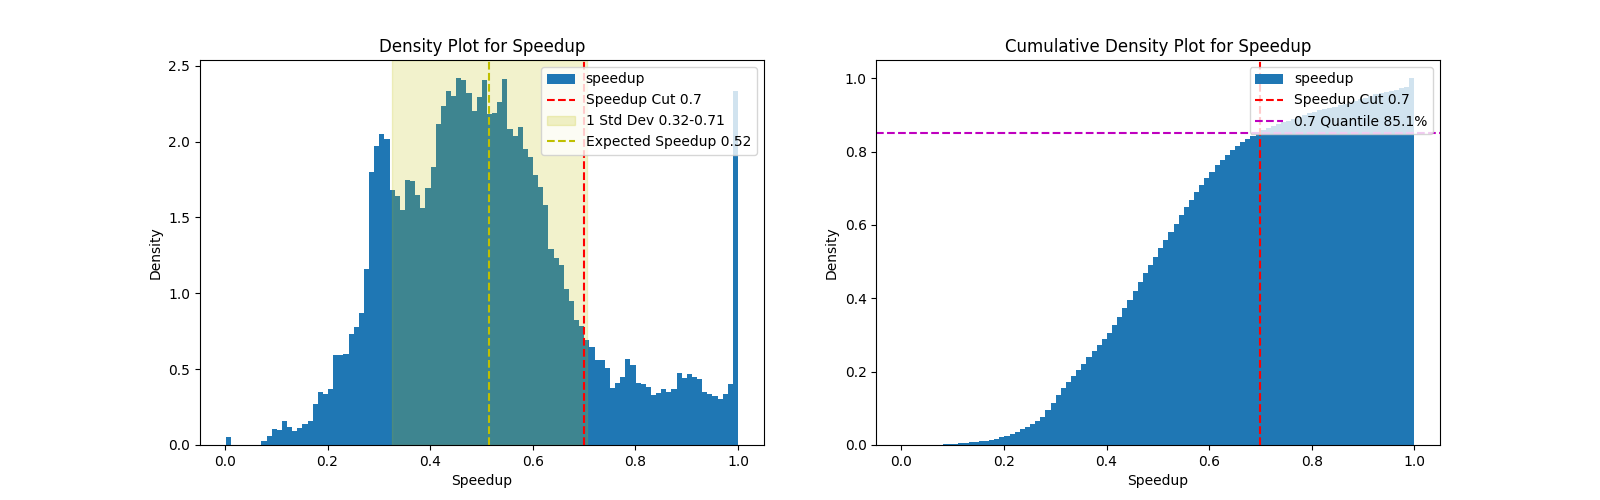

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# relative performance
grouped_speedup["speedup"].plot.hist(
    bins=100, ax=ax[0], density=True)
ax[0].set_title("Density Plot for Speedup")
ax[0].set_xlabel("Speedup")
ax[0].set_ylabel("Density")
ax[0].axvline(x=SPEEDUP_CUT, color='r',
              linestyle='--', label=f"Speedup Cut {SPEEDUP_CUT}")

expectation = grouped_speedup["speedup"].mean()
std_dev = grouped_speedup["speedup"].std()

ax[0].axvspan(expectation-std_dev, expectation+std_dev, color='y', alpha=0.2,
              label=f"1 Std Dev {np.round(expectation-std_dev, 2)}-{np.round(expectation+std_dev, 2)}")

ax[0].axvline(x=expectation, color='y', linestyle='--',
              label=f"Expected Speedup {np.round(expectation, 2)}")

ax[0].legend(loc='upper right')

# cummulative distribution
grouped_speedup["speedup"].plot.hist(
    bins=100, ax=ax[1], density=True, cumulative=True)
ax[1].set_title("Cumulative Density Plot for Speedup")
ax[1].set_xlabel("Speedup")
ax[1].set_ylabel("Density")
ax[1].axvline(x=SPEEDUP_CUT, color='r',
              linestyle='--', label=f"Speedup Cut {np.round(SPEEDUP_CUT, 2)}")

value_at_top_performance = 1-len(filtered_groups) / len(df)

ax[1].axhline(y=value_at_top_performance, color='m',
              linestyle='--', label=f"{SPEEDUP_CUT} Quantile {np.round(100*value_at_top_performance, 2)}%")
ax[1].legend(loc='upper right')

# Filter Data / Outliers


In [50]:
Z_THRESHHOLD = 3
for column in inputs:
    z = np.abs(stats.zscore(combined[column]))
    combined = combined[z < Z_THRESHHOLD]

print("Outliers removed length", len(combined))


# filter values occuring less than pct
SPARSE_CUTOFF = 0.01
for column in outputs:
    counts = combined[column].value_counts()

    sparse_values = combined[column].isin(
        counts[counts > len(combined) * SPARSE_CUTOFF].index)

    combined = combined[sparse_values]


print("Sparse values removed length", len(combined))

X, y = combined[inputs], combined[outputs]
print(X.shape, y.shape)

Outliers removed length 3067
Sparse values removed length 2665
(2665, 6) (2665, 3)


# Create Train and Test Data


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# save to csv
pd.concat([X_train, y_train], axis=1).to_pickle("train.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("test.pkl")

# Final Data


In [52]:
pd.concat([X_train, y_train], axis=1).head()

avgParticlesPerCell  homogeneity  maxDensity  maxParticlesPerCell  \
1883             0.905797     0.051898    0.304984                   17   
2336             0.944637     0.080565    0.624960                   23   
2078             0.905797     0.055390    0.301437                   17   
2780             0.944637     0.083028    0.725400                   26   
2481             0.944637     0.081520    0.472440                   19   

      particlesPerCellStdDev  threadCount  \
1883                0.014717           28   
2336                0.040478           12   
2078                0.015106           24   
2780                0.040245            1   
2481                0.040467            1   

                                   Container_DataLayout  \
1883  VerletClusterLists_SoA, VerletListsCells_AoS, ...   
2336  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
2078  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
2780  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   
2481  LinkedCells_SoA, VerletClusterLists_SoA, Verle...   

                                              Traversal Newton 3  
1883                   vcl_c06, vlc_c18, vlc_sliced_c02  enabled  
2336  lc_c04, lc_c08, lc_sliced, lc_sliced_balanced,...  enabled  
2078  lc_sliced, lc_sliced_balanced, lc_sliced_c02, ...  enabled  
2780  lc_c04, lc_c08, lc_c18, lc_sliced, lc_sliced_b...  enabled  
2481  lc_c04, lc_c08, lc_c18, lc_sliced, lc_sliced_b...  enabled

In [53]:
for i, col in enumerate(y.columns):

    y_count = y[col].value_counts()

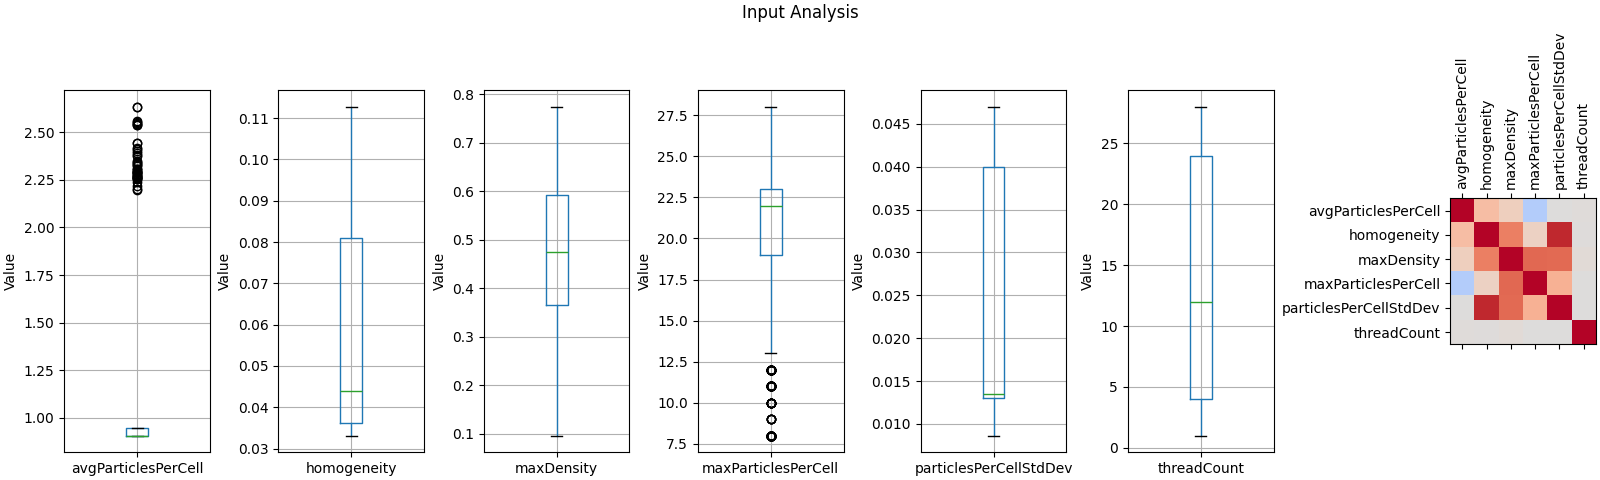

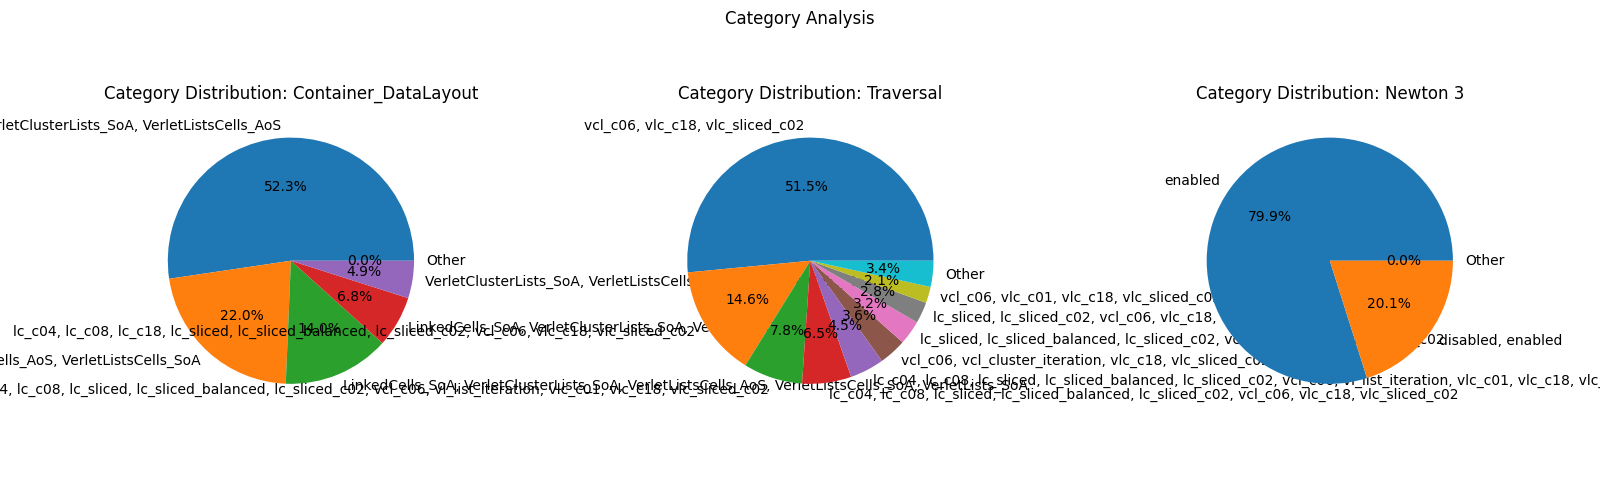

In [54]:
import seaborn as sns

# Row 1
fig, ax1 = plt.subplots(1, len(X.columns)+1, constrained_layout=True)

fig.suptitle("Input Analysis")
fig.set_figwidth(16)

for i, col in enumerate(X.columns):
    X[[col]].boxplot(ax=ax1[i], showfliers=True)
    ax1[i].set_ylabel("Value")

i += 1
# Correlation Matrix
corr = X.corr()
cax = ax1[i].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax1[i].set_xticks(range(len(X.columns)))
ax1[i].set_yticks(range(len(X.columns)))
ax1[i].set_xticklabels(X.columns, rotation=90)
ax1[i].set_yticklabels(X.columns)


# Row 2
fig, ax1 = plt.subplots(1, len(y_train.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(16)
fig.tight_layout(pad=3.0)


for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()

    total = y_count.sum()

    # grouping categories with less than 2% of the total
    y_count_group = y_count[y_count.gt(total*0.02)]
    y_count_group["Other"] = y_count[~y_count.index.isin(
        y_count_group.index)].sum()

    ax1[i].pie(y_count_group, labels=y_count_group.index, autopct='%1.1f%%')
    ax1[i].set_title(f"Category Distribution: {col}")

# Train Decision Tree and Extract Rules


In [55]:
# number of input parameters that can be used simultaneously
POSSIBLE_NUMBER_OF_COMBINATIONS = [2, 3, 4, 5]

CCP_ALPHA = {
    "Container_DataLayout": 0.1,
    "Traversal": 0.08,
    "Newton 3": 0.02,
}

# maximum depth of the decision tree
MAX_DEPTH = 10

# how many models should be created for each label
TOP_K_MODELS_PER_LABEL = 2


Training on 2132 samples


Number of rules 44:
	Container_DataLayout (14 rules)
	Traversal (16 rules)
	Newton 3 (14 rules)


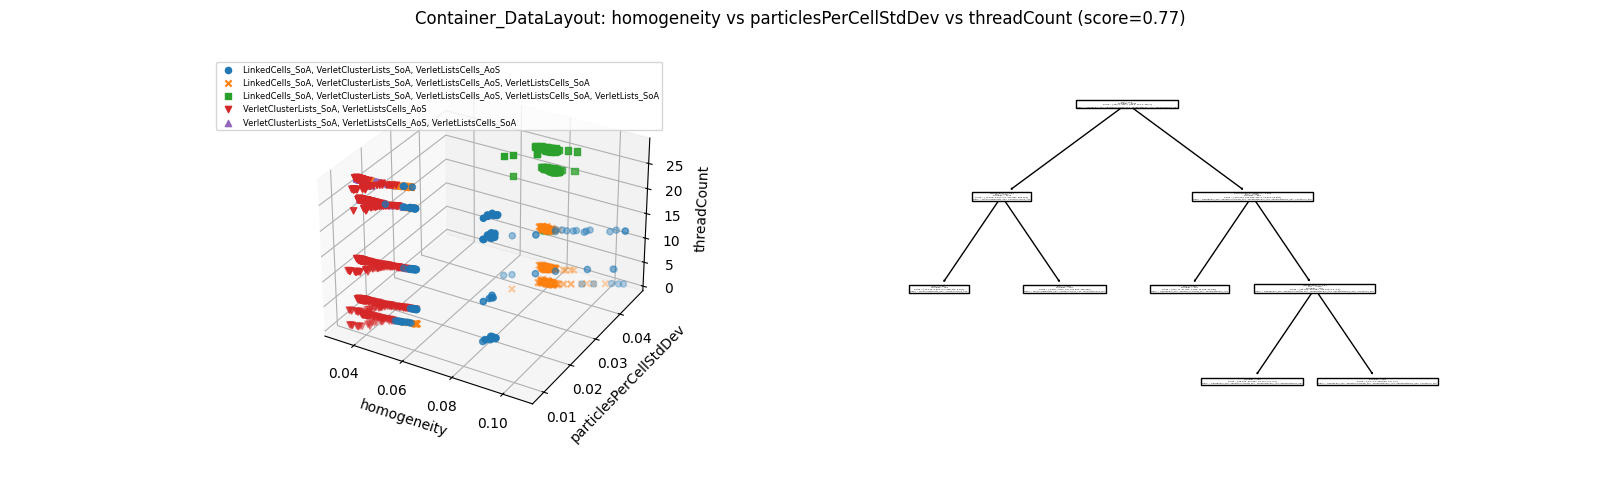

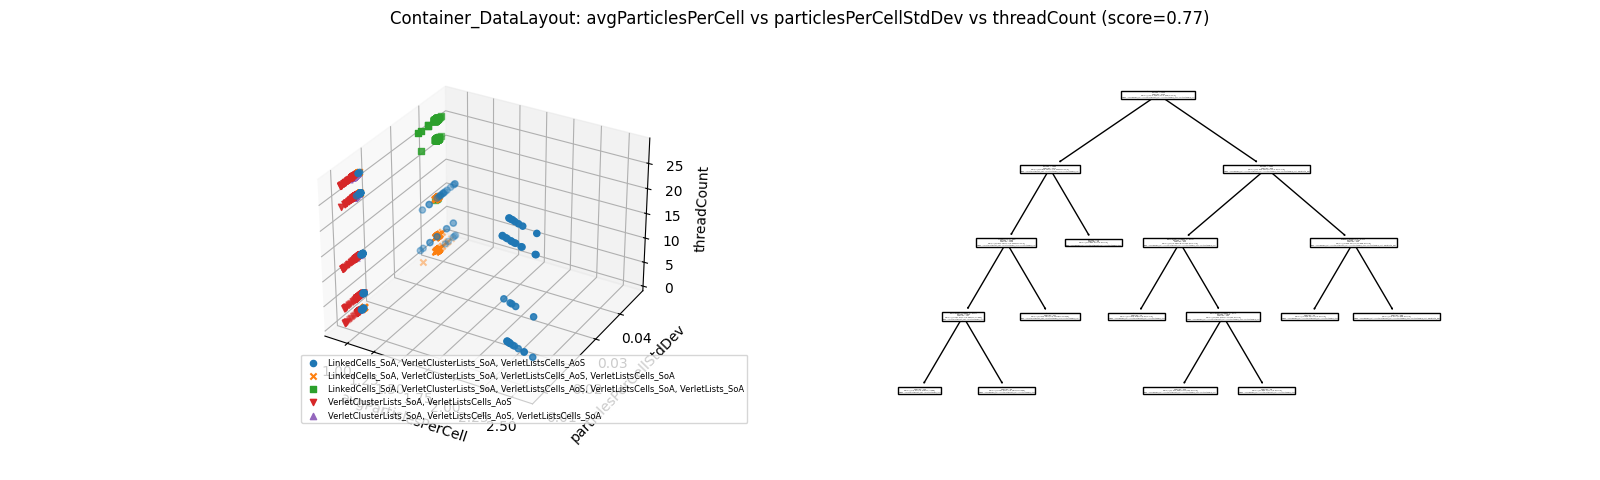

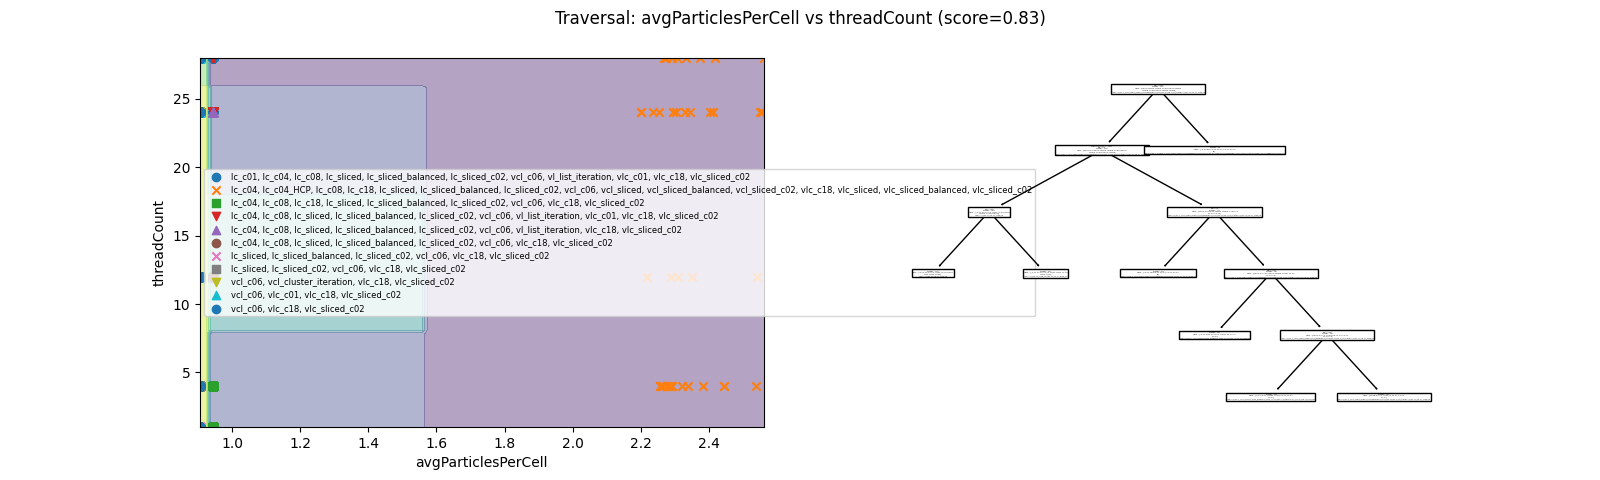

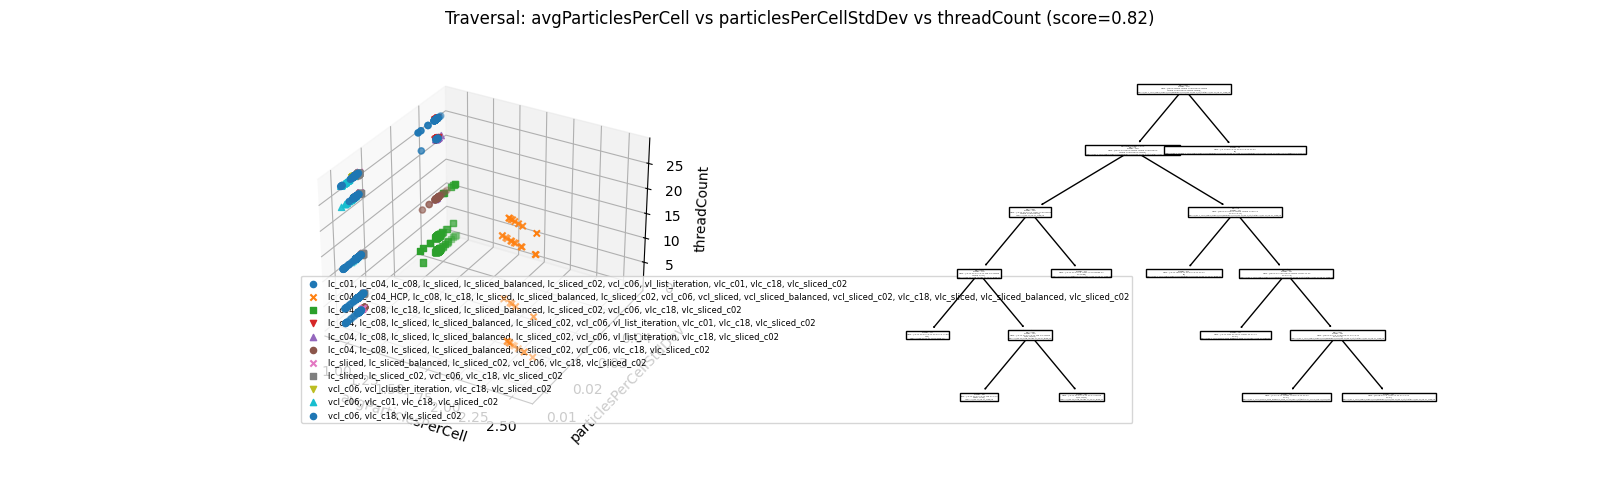

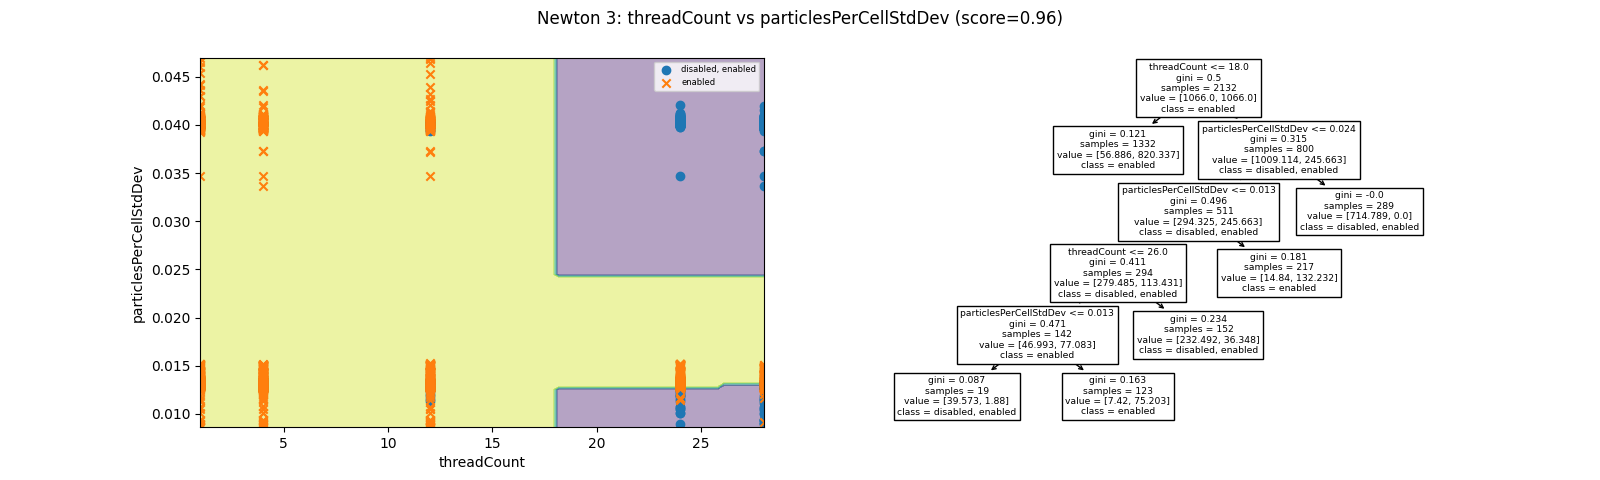

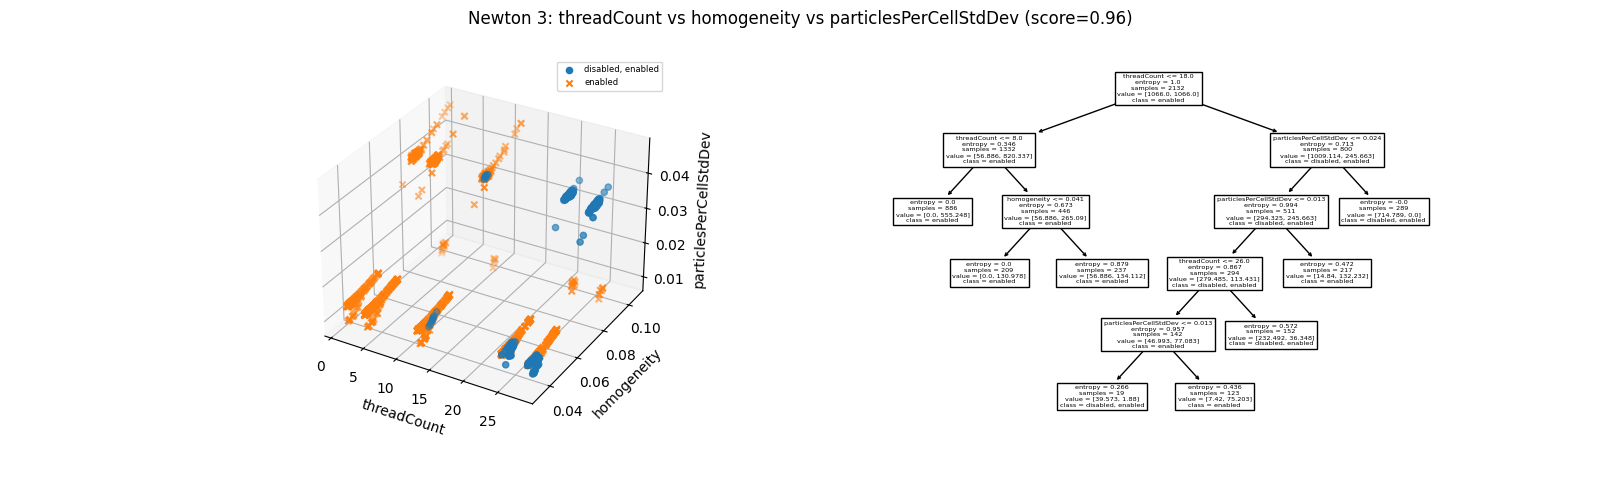

In [56]:
auto_rules = create_auto_rules(X_train, y_train,  None,
                               POSSIBLE_NUMBER_OF_COMBINATIONS, CCP_ALPHA, MAX_DEPTH, TOP_K_MODELS_PER_LABEL)

homogeneity: [-inf, 0.041, 0.049, inf]
homogeneity: [-inf, 0.041, 0.049, inf]

threadCount: [-inf, 8.0, 18.0, 26.0, inf]
threadCount: [-inf, 8.0, 18.0, 26.0, inf]

particlesPerCellStdDev: [-inf, 0.013, 0.014, 0.015, 0.024, 0.038, 0.041, inf]
particlesPerCellStdDev: [-inf, 0.013, 0.015, 0.024, 0.038, 0.041, inf]

avgParticlesPerCell: [-inf, 0.925, 1.553, 1.572, inf]
avgParticlesPerCell: [-inf, 0.925, 1.553, inf]



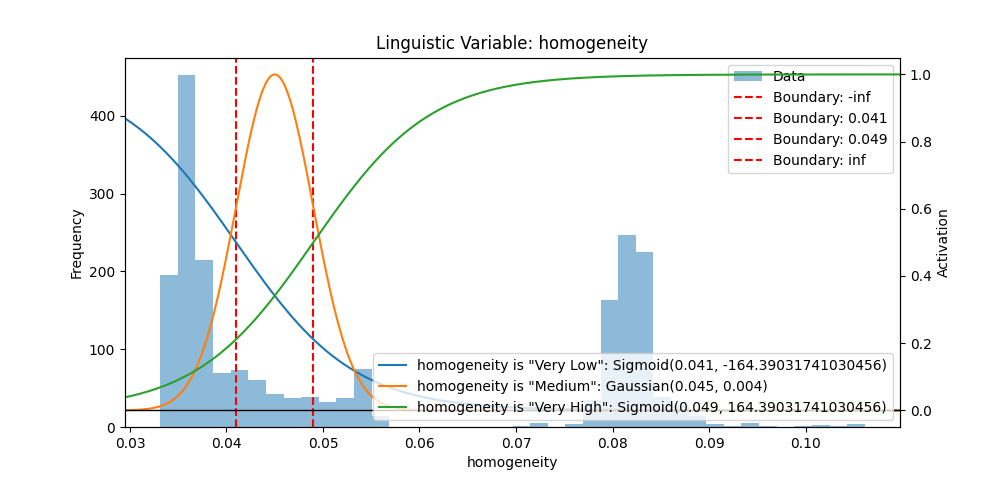

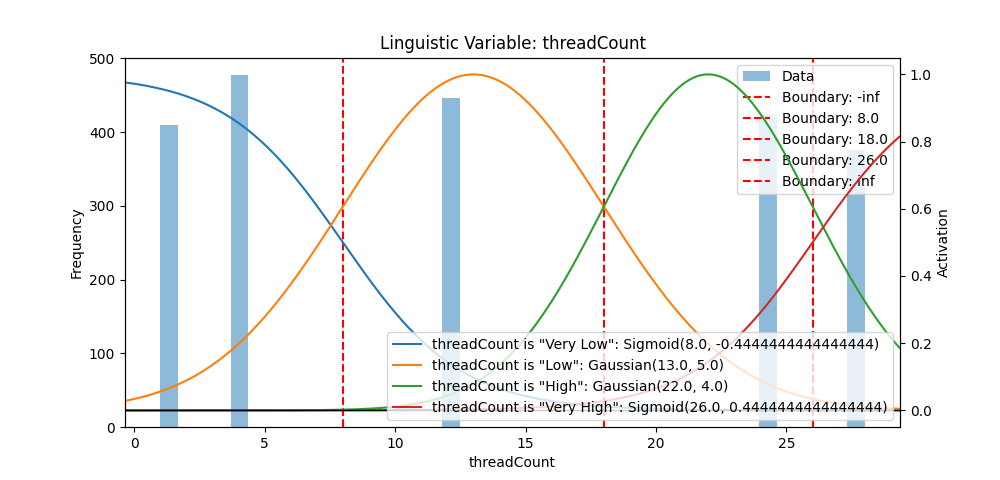

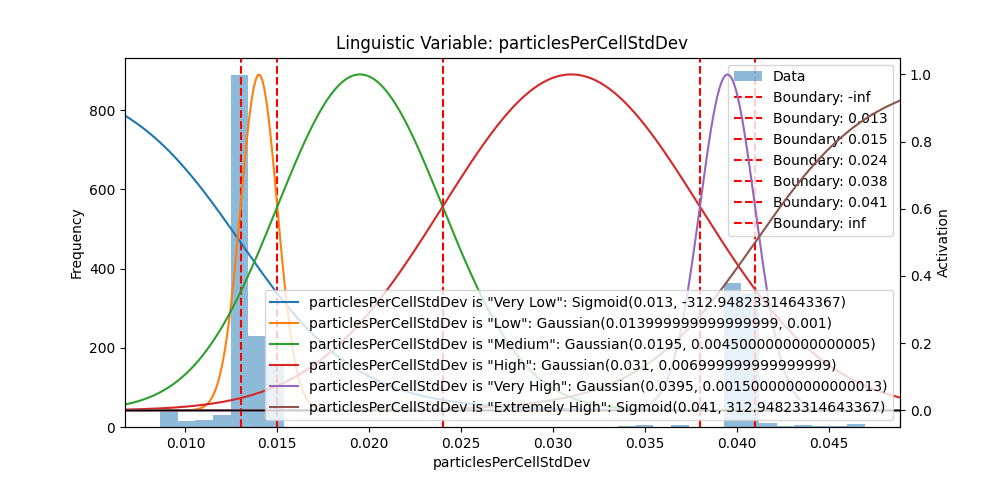

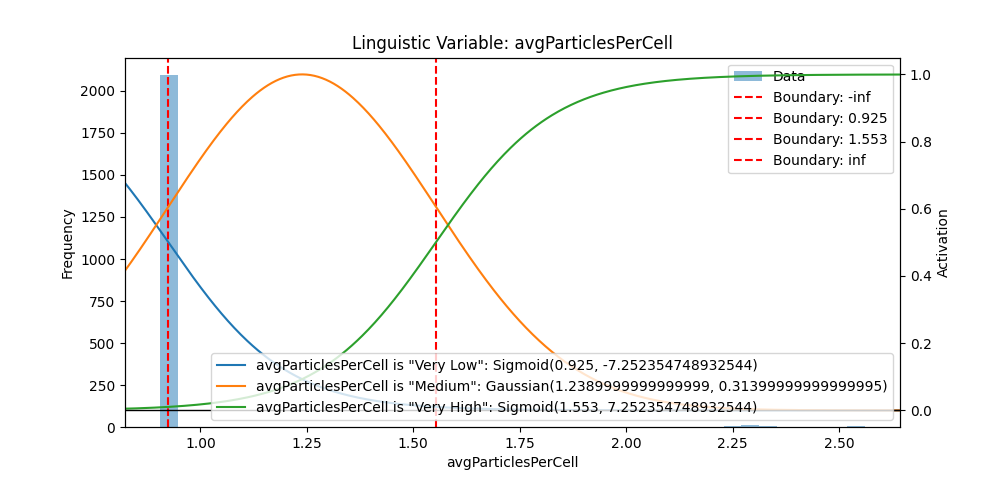

In [57]:
inputs_approach1, rules_approach1 = create_rules_approach1(
    X_train, auto_rules)

# Aproach 2

Follows https://www.sciencedirect.com/science/article/pii/S0165011406002533


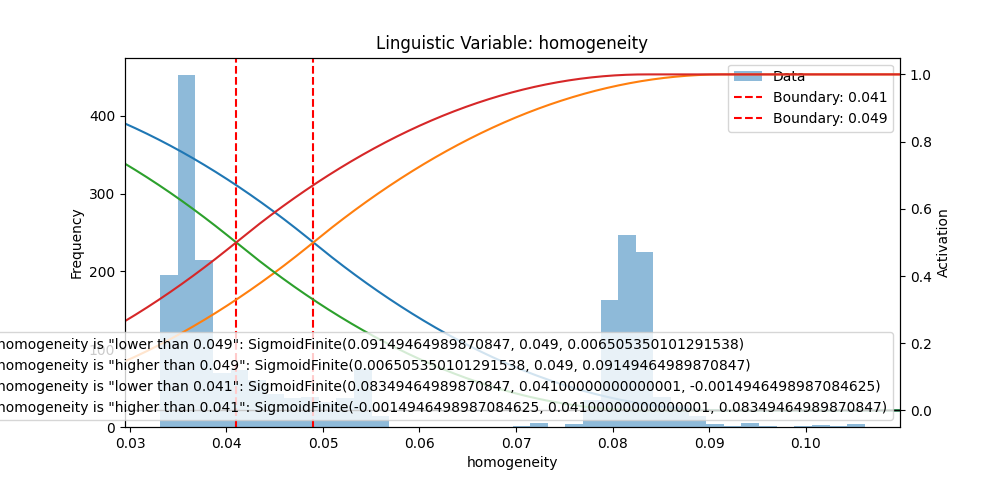

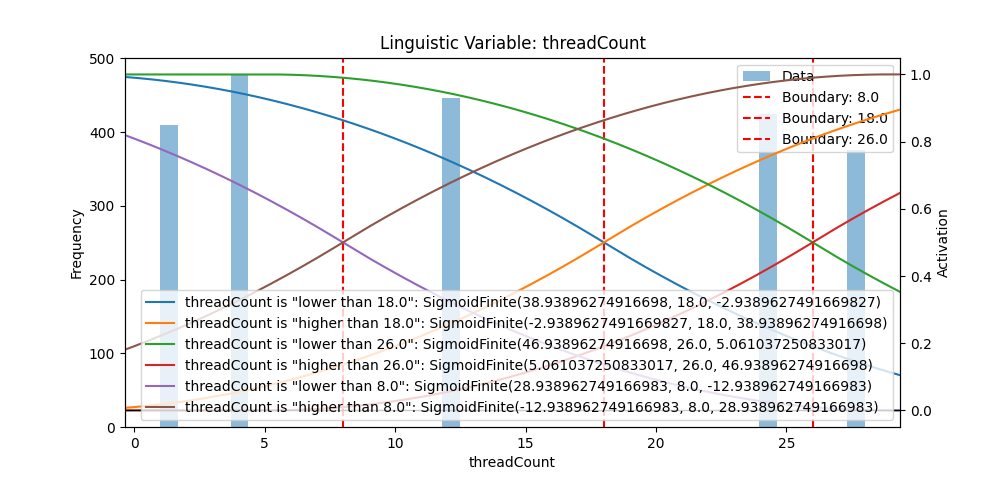

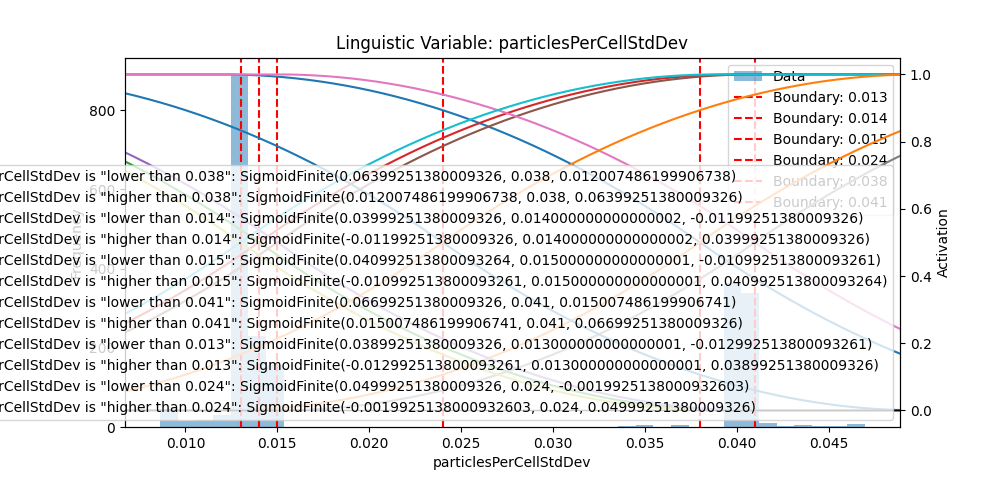

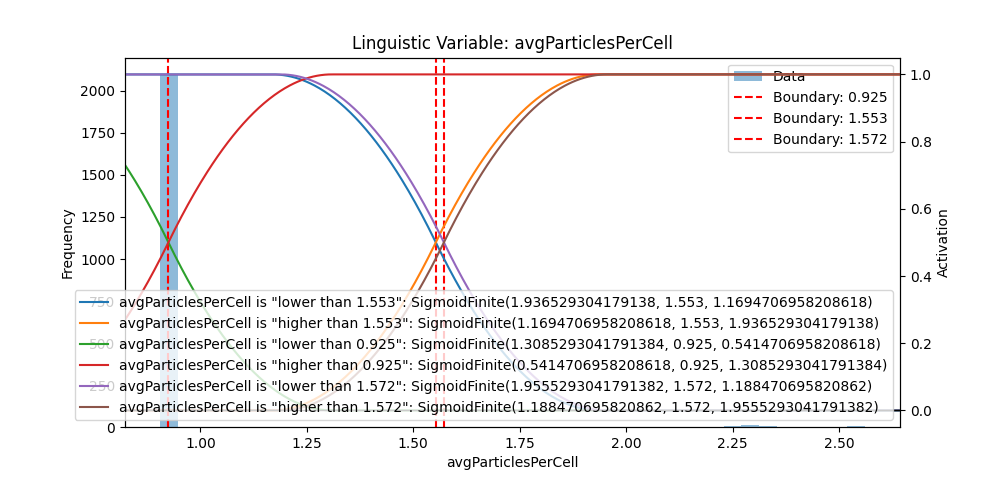

In [58]:
inputs_approach_2, rules_approach2 = create_rules_approach2(
    X_train, auto_rules)

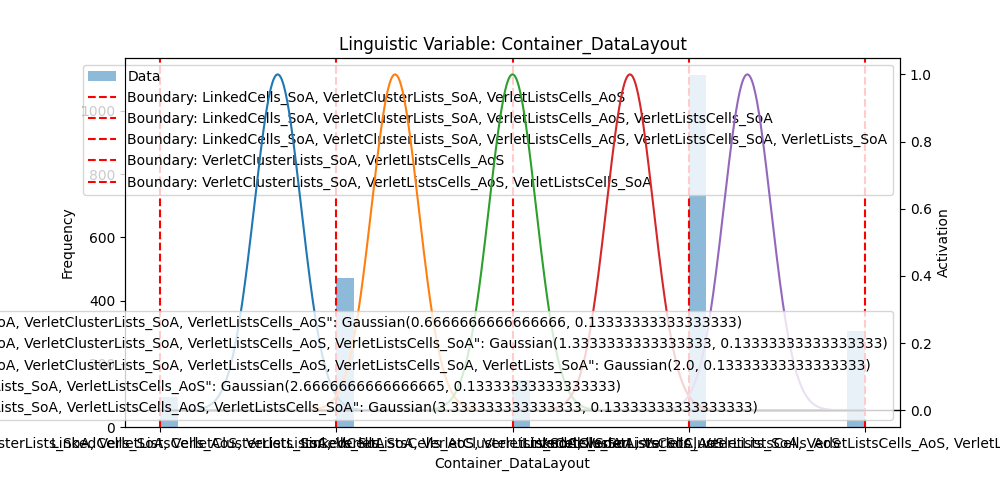

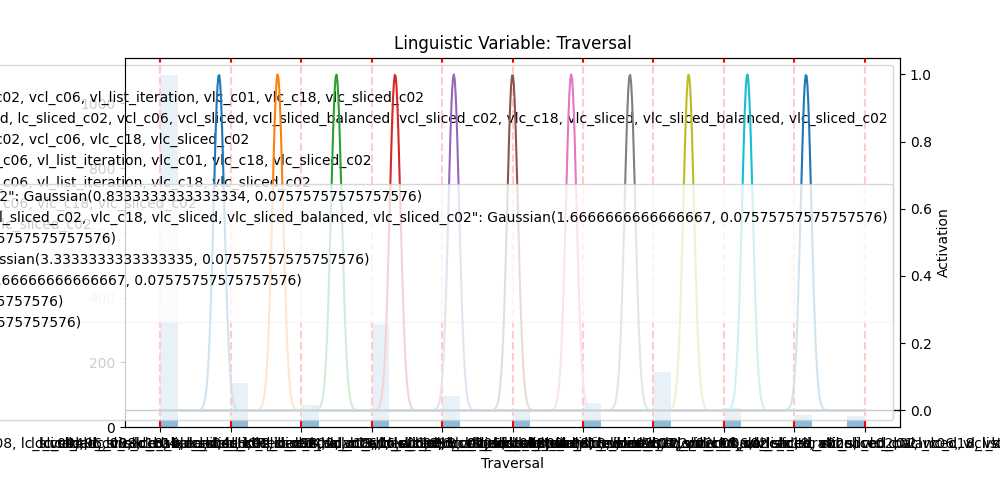

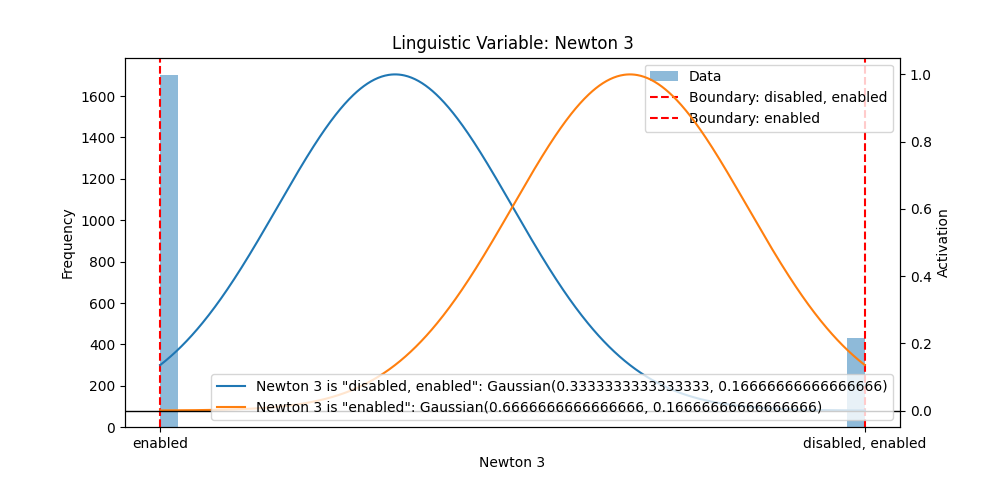

In [59]:
outputRangeMembershipFunctions = create_output_membership_functions(y_train)

# Save all the data


In [60]:
save_linguistic_variables(inputs_approach1, "approach1/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach1/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach1, "approach1/fuzzy-rules.txt")


save_linguistic_variables(inputs_approach_2, "approach2/fuzzy-inputs.txt")
save_linguistic_variables(outputRangeMembershipFunctions,
                          "approach2/fuzzy-outputs.txt")

save_fuzzy_rules(rules_approach2, "approach2/fuzzy-rules.txt")

FuzzyVariable: domain: "homogeneity" range: (-0.009356649898708463, 0.14862964989870847)
	"Very Low": Sigmoid(0.041, -164.39031741030456)
	"Medium": Gaussian(0.045, 0.004)
	"Very High": Sigmoid(0.049, 164.39031741030456)

FuzzyVariable: domain: "threadCount" range: (-19.938962749166983, 48.93896274916698)
	"Very Low": Sigmoid(8.0, -0.4444444444444444)
	"Low": Gaussian(13.0, 5.0)
	"High": Gaussian(22.0, 4.0)
	"Very High": Sigmoid(26.0, 0.4444444444444444)

FuzzyVariable: domain: "particlesPerCellStdDev" range: (-0.01736451380009326, 0.07296551380009327)
	"Very Low": Sigmoid(0.013, -312.94823314643367)
	"Low": Gaussian(0.013999999999999999, 0.001)
	"Medium": Gaussian(0.0195, 0.0045000000000000005)
	"High": Gaussian(0.031, 0.006999999999999999)
	"Very High": Gaussian(0.0395, 0.0015000000000000013)
	"Extremely High": Sigmoid(0.041, 312.94823314643367)

FuzzyVariable: domain: "avgParticlesPerCell" range: (0.5222676958208617, 2.943961304179138)
	"Very Low": Sigmoid(0.925, -7.252354748932544)